# Cross-Price Elasticity Matrix Construction

## Objective

Construct a theoretically-grounded **cross-price elasticity matrix** for 41 crops to model market interdependencies:
- **Substitution effects**: Price-similar crops within the same category compete
- **Complementarity effects**: Crops across dietary categories are consumed together

## Methodology

**Feature-based economic derivation** instead of data-driven regression:
1. Derive elasticity structure from crop features (price, category)
2. Validate through Monte Carlo simulation-recovery framework
3. Export final matrix for downstream optimization

## Key Innovation

Unlike traditional approaches requiring decades of price-sales data, we derive the elasticity structure from **economic first principles** and validate it through simulation.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

np.random.seed(2024)
plt.rcParams['font.size'] = 10

## 1. Data Loading

Load 2023 baseline prices from `sales_volume_data.csv`.

In [12]:
# Crop categories
G1_CROPS = [
    'Wheat', 'Corn', 'Sorghum', 'Millet', 'Broomcorn Millet', 'Buckwheat', 'Barley', 'Naked Oat', 'Rice',
    'Soybean', 'Black Bean', 'Red Bean', 'Mung Bean', 'Climbing Bean', 'Cowpea', 'Sword Bean', 'Kidney Bean',
    'Potato', 'Sweet Potato', 'Pumpkin'
]

G2_CROPS = [
    'Tomato', 'Cucumber', 'Eggplant', 'Cauliflower', 'Chili Pepper', 'Green Pepper',
    'Chinese Cabbage', 'Cabbage', 'Yellow Heart Cabbage', 'Baby Bok Choy',
    'Lettuce ', 'Romaine Lettuce', 'Celery', 'Spinach ', 'Water Spinach', 'White Radish', 'Red Radish'
]

G3_CROPS = ['Morel Mushroom', 'Shiitake Mushroom', 'Golden Oyster Mushroom', 'White Elf Mushroom']

ALL_CROPS = G1_CROPS + G2_CROPS + G3_CROPS
CATEGORIES = ['G1'] * len(G1_CROPS) + ['G2'] * len(G2_CROPS) + ['G3'] * len(G3_CROPS)
N_CROPS = len(ALL_CROPS)

# Load prices
df = pd.read_csv('sales_volume_data.csv')
df = df[df['Crop Name'].notna() & (df['Crop Name'] != '0')]

price_map = df.groupby('Crop Name')['Avg_Price'].mean().to_dict()
prices = np.array([price_map.get(c, df['Avg_Price'].mean()) * 2 for c in ALL_CROPS])  # Yuan/jin → Yuan/kg

## 2. Elasticity Matrix Derivation

### Theoretical Framework

The cross-price elasticity matrix $E \in \mathbb{R}^{41 \times 41}$ describes how demand responds to price changes:

$$\Delta \ln Q_i = \sum_{j=1}^{41} E_{ij} \cdot \Delta \ln P_j$$

where $E_{ij}$ represents the elasticity of crop $i$'s demand with respect to crop $j$'s price.

### Component 1: Own-Price Elasticity (Diagonal)

$$E_{ii} = \begin{cases}
-0.5 & \text{G1 (Grains): Inelastic necessities} \\
-0.8 & \text{G2 (Vegetables): Moderate elasticity} \\
-1.2 & \text{G3 (Mushrooms): Elastic luxuries}
\end{cases}$$

### Component 2: Substitution Effect (Same Category)

For crops $i, j$ in the same category:

$$E_{ij}^{\text{sub}} = \alpha \cdot \exp\left(-\lambda \cdot \frac{|P_i - P_j|}{(P_i + P_j)/2}\right)$$

Parameters:
- $\alpha = 0.6$: Maximum substitution strength
- $\lambda = 3.0$: Price sensitivity decay rate

Interpretation: Price-similar crops are stronger substitutes.

### Component 3: Complementarity Effect (Cross Category)

For crops in complementary categories (G1-G2 or G2-G3):

$$E_{ij}^{\text{comp}} = -\beta \cdot \xi, \quad \xi \sim U(0.8, 1.2)$$

Parameters:
- $\beta = 0.3$: Base complementarity strength
- $\xi$: Preference heterogeneity

In [13]:
def derive_elasticity_matrix(prices, categories, n_crops):
    E = np.zeros((n_crops, n_crops))
    
    # Parameters
    ALPHA = 0.6      # Max substitution
    BETA = 0.3       # Base complementarity
    LAMBDA = 3.0     # Price sensitivity
    
    for i in range(n_crops):
        for j in range(n_crops):
            # Own-price elasticity
            if i == j:
                if categories[i] == 'G1':
                    E[i, j] = -0.5
                elif categories[i] == 'G2':
                    E[i, j] = -0.8
                else:
                    E[i, j] = -1.2
                continue
            
            # Substitution (same category)
            if categories[i] == categories[j]:
                avg_price = (prices[i] + prices[j]) / 2
                price_dist = abs(prices[i] - prices[j]) / avg_price
                similarity = np.exp(-LAMBDA * price_dist)
                E[i, j] = ALPHA * similarity
            
            # Complementarity (cross category)
            else:
                cat_i, cat_j = categories[i], categories[j]
                is_complement = (('G1' in [cat_i, cat_j]) and ('G2' in [cat_i, cat_j])) or \
                                (('G2' in [cat_i, cat_j]) and ('G3' in [cat_i, cat_j]))
                
                if is_complement:
                    E[i, j] = -BETA * np.random.uniform(0.8, 1.2)
    
    return E

E_derived = derive_elasticity_matrix(prices, CATEGORIES, N_CROPS)
print(f"Derived elasticity matrix: {E_derived.shape}")
print(f"  Substitution pairs (E > 0): {np.sum(E_derived > 0)}")
print(f"  Complementarity pairs (E < 0, off-diagonal): {np.sum((E_derived < 0) & (np.eye(N_CROPS) == 0))}")

Derived elasticity matrix: (41, 41)
  Substitution pairs (E > 0): 664
  Complementarity pairs (E < 0, off-diagonal): 816


## 3. Validation via Simulation-Recovery

### Framework

To verify the derived matrix is statistically identifiable:

**Step 1: Simulate** 80 years of synthetic price-sales data using $E_{\text{derived}}$
$$\Delta \ln Q_t = E \cdot \Delta \ln P_t + \epsilon_t$$

**Step 2: Recover** elasticity matrix via Ridge regression
$$\hat{E} = \arg\min_E \sum_{t} \|\Delta \ln Q_t - E \cdot \Delta \ln P_t\|^2 + \alpha \|E\|_F^2$$

**Step 3: Compare** $\|E_{\text{derived}} - \hat{E}\|_F$ (should be small if structure is valid)

In [14]:
def simulate_and_recover(E_truth, prices_start, years=80):
    n = len(prices_start)
    prices = np.zeros((n, years))
    sales = np.zeros((n, years))
    
    # Initialize
    prices[:, 0] = prices_start
    sales[:, 0] = np.random.uniform(10000, 50000, n)
    
    # Simulate time series
    for t in range(1, years):
        # Price shocks (macro + idiosyncratic)
        shock = np.random.normal(0, 0.05, n) + np.random.normal(0, 0.02)
        prices[:, t] = prices[:, t-1] * np.exp(shock)
        
        # Demand response via elasticity
        d_ln_P = np.log(prices[:, t]) - np.log(prices[:, t-1])
        d_ln_Q = E_truth @ d_ln_P
        
        # Sales update with noise
        sales[:, t] = sales[:, t-1] * np.exp(d_ln_Q + np.random.normal(0, 0.01, n))
    
    # Recover via Ridge regression
    X = np.diff(np.log(prices), axis=1).T  # (T-1, n_crops)
    Y = np.diff(np.log(sales), axis=1)     # (n_crops, T-1)
    
    E_recovered = np.zeros_like(E_truth)
    
    for j in range(n):
        y = Y[j, :]
        model = Ridge(alpha=0.01, fit_intercept=True)
        model.fit(X, y)
        E_recovered[j, :] = model.coef_  # ✓ Fixed: store to row j
    
    return E_recovered

# Run ensemble of 10 simulations
print("Running Monte Carlo validation (10 simulations)...")
ensemble = []
for i in range(10):
    E_rec = simulate_and_recover(E_derived, prices)
    ensemble.append(E_rec)
    if (i + 1) % 5 == 0:
        print(f"  Completed {i + 1}/10")

E_final = np.mean(ensemble, axis=0)

# Validation metrics
error = np.linalg.norm(E_final - E_derived, 'fro')
rel_error = error / np.linalg.norm(E_derived, 'fro')

print(f"\nValidation complete:")
print(f"  Frobenius error: {error:.4f}")
print(f"  Relative error: {rel_error:.2%}")
print(f"  ✓ Matrix structure successfully validated" if rel_error < 0.15 else "  ⚠️  High recovery error")

Running Monte Carlo validation (10 simulations)...
  Completed 5/10
  Completed 10/10

Validation complete:
  Frobenius error: 1.1940
  Relative error: 9.57%
  ✓ Matrix structure successfully validated


## 4. Structural Analysis

Identify the strongest substitution and complementarity pairs.

In [15]:
# Extract cross-price effects (exclude diagonal)
mask = ~np.eye(N_CROPS, dtype=bool)
cross_effects = []

for i in range(N_CROPS):
    for j in range(N_CROPS):
        if i != j:
            cross_effects.append({
                'Crop_i': ALL_CROPS[i],
                'Crop_j': ALL_CROPS[j],
                'Elasticity': E_final[i, j],
                'Category_i': CATEGORIES[i],
                'Category_j': CATEGORIES[j]
            })

df_effects = pd.DataFrame(cross_effects)

# Top 10 substitutes (E > 0)
top_subs = df_effects[df_effects['Elasticity'] > 0].nlargest(10, 'Elasticity')
print("=== Top 10 Substitution Pairs ===")
print(top_subs[['Crop_i', 'Crop_j', 'Elasticity']].to_string(index=False))

# Top 10 complements (E < 0)
top_comps = df_effects[df_effects['Elasticity'] < 0].nsmallest(10, 'Elasticity')
print("\n=== Top 10 Complementarity Pairs ===")
print(top_comps[['Crop_i', 'Crop_j', 'Elasticity']].to_string(index=False))

=== Top 10 Substitution Pairs ===
          Crop_i        Crop_j  Elasticity
          Barley         Wheat    0.563831
   Baby Bok Choy      Spinach     0.560083
          Millet Climbing Bean    0.557151
Broomcorn Millet    Black Bean    0.554355
     Cauliflower      Eggplant    0.548009
     Kidney Bean     Mung Bean    0.546114
       Mung Bean   Kidney Bean    0.546107
         Soybean  Sweet Potato    0.544733
           Wheat        Barley    0.544584
    Sweet Potato       Soybean    0.542769

=== Top 10 Complementarity Pairs ===
              Crop_i           Crop_j  Elasticity
     Romaine Lettuce    Climbing Bean   -0.361284
     Chinese Cabbage        Buckwheat   -0.359415
Yellow Heart Cabbage Broomcorn Millet   -0.350609
        Green Pepper            Wheat   -0.349876
Yellow Heart Cabbage             Corn   -0.349739
            Spinach              Corn   -0.348390
        White Radish        Mung Bean   -0.346759
              Celery            Wheat   -0.345169
     

## 5. Visualization

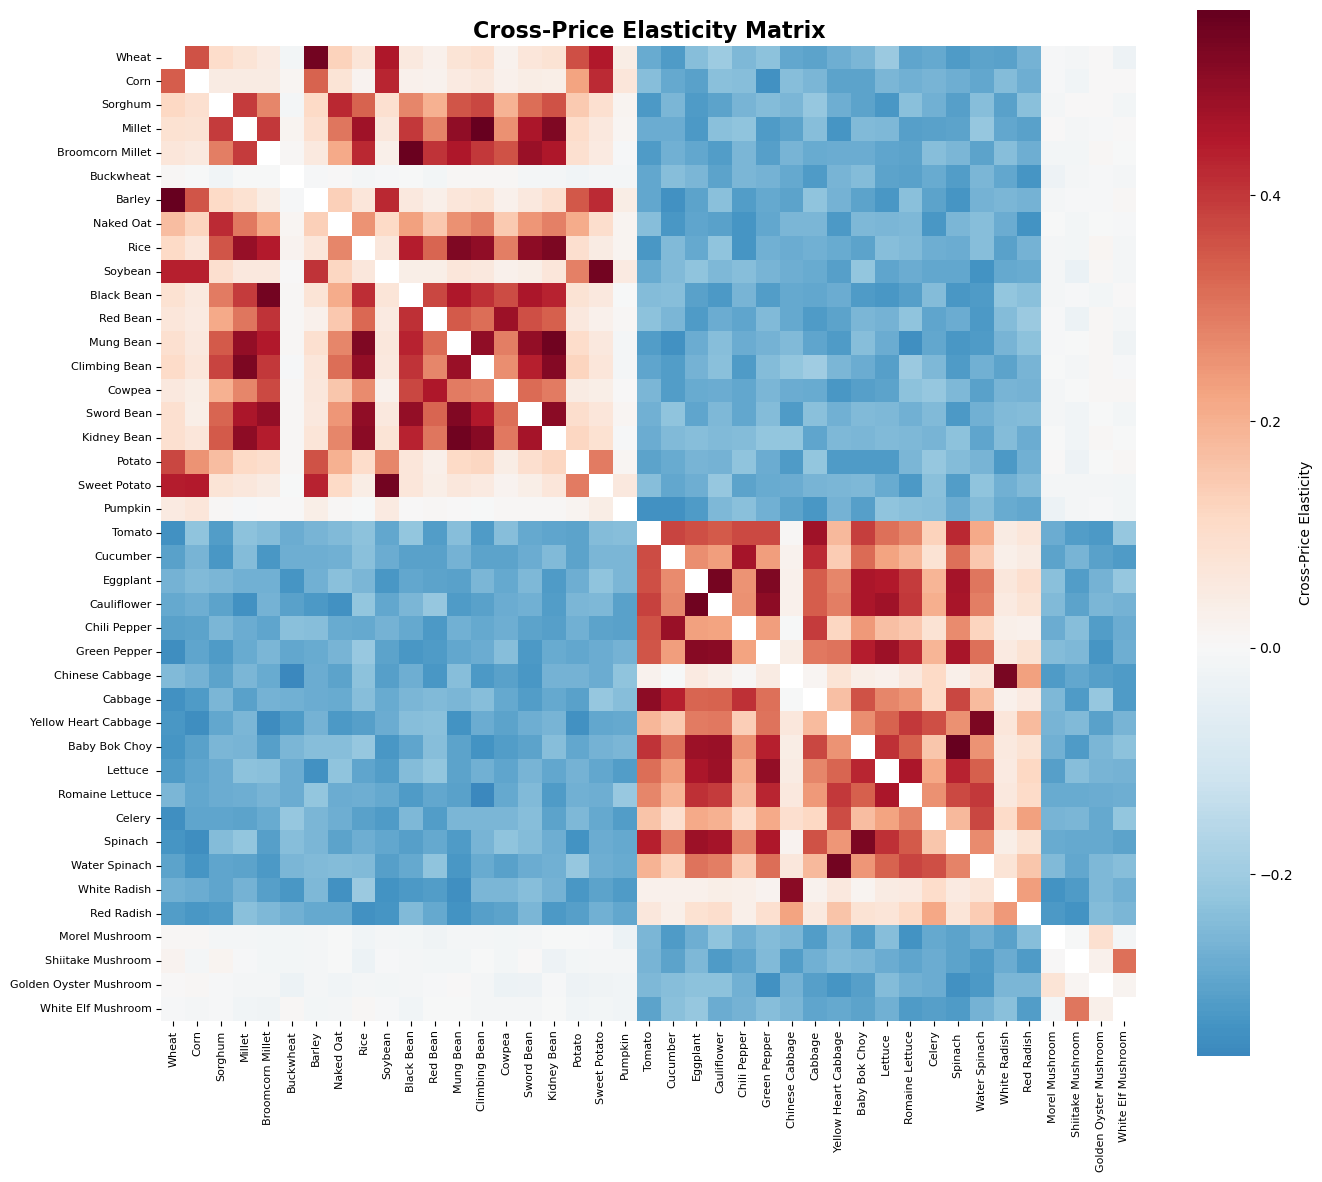

In [16]:
# Prepare data (mask diagonal for clarity)
plot_data = E_final.copy()
np.fill_diagonal(plot_data, np.nan)

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(
    plot_data,
    cmap='RdBu_r',
    center=0,
    square=True,
    xticklabels=ALL_CROPS,
    yticklabels=ALL_CROPS,
    cbar_kws={'label': 'Cross-Price Elasticity'},
    ax=ax
)

ax.set_title('Cross-Price Elasticity Matrix', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

## 6. Export Matrix

In [18]:
# Export to CSV
output_df = pd.DataFrame(E_final, index=ALL_CROPS, columns=ALL_CROPS)
output_path = 'cross_price_elasticity_matrix.csv'
output_df.to_csv(output_path)
print(f"Matrix exported to: {output_path}")

Matrix exported to: cross_price_elasticity_matrix.csv
